# Autoencoder for MNIST compared to supervised model

### Imports and load the MNIST dataset

In [34]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


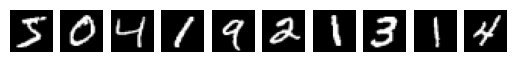

In [35]:
# Plot the first 10 images
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')

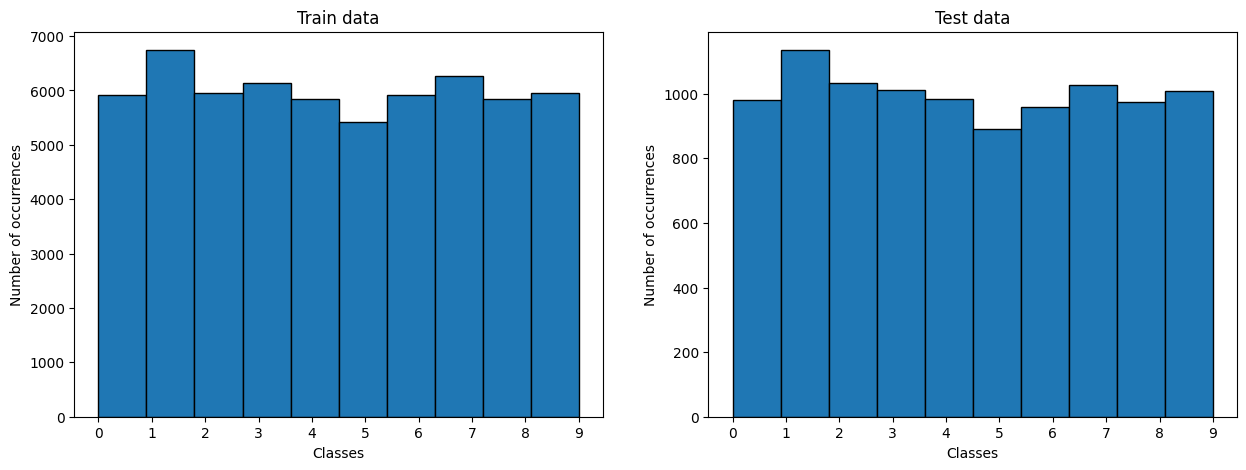

In [36]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
axs[0].hist(y_train, ec='black')
axs[0].set_title('Train data')
axs[0].set_xlabel('Classes') 
axs[0].set_ylabel('Number of occurrences')
axs[1].hist(y_test, ec='black')
axs[1].set_title('Test data')
axs[1].set_xlabel('Classes') 
axs[1].set_ylabel('Number of occurrences')
# We want to show all ticks...
axs[0].set_xticks(np.arange(10))
axs[1].set_xticks(np.arange(10))

plt.show()

### Vector size for latent variables and number of epochs

In [37]:
LATENT_SIZE = 32
EPOCHS = 10

### Define the autoencoder model consisting of an encoder and decoder

In [38]:
# Autoencoder using CNN layers
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)),
    tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(LATENT_SIZE, activation="relu")
])

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(7 * 7 * 32, input_shape=(LATENT_SIZE,)),
    tf.keras.layers.Reshape((7, 7, 32)),
    tf.keras.layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same"),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2DTranspose(16, (3, 3), activation="relu", padding="same"),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same"),
    tf.keras.layers.Reshape((28, 28))
])

img = tf.keras.layers.Input(shape = (28, 28))
latent_vector = encoder(img)
output = decoder(latent_vector)
autoencoder = tf.keras.models.Model(inputs = img, outputs = output)

### Compile and train the autoencoder

In [ ]:
autoencoder.compile("nadam", loss = "binary_crossentropy")

history = autoencoder.fit(x_train, x_train, epochs=EPOCHS)

### Fine-tune the model with supervised learning with 10% of the training data

In [8]:
# Set up the model
model = tf.keras.models.Sequential([
    encoder,
    tf.keras.layers.Dense(10, activation="softmax")
])

# Compile the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Use 1% of the labeled training examples for supervised learning
x_train_supervised = x_train[:600]
y_train_supervised = y_train[:600]

# Train the model
model.fit(
    x_train_supervised,
    y_train_supervised,
    epochs=EPOCHS,
)

# Evaluate the model on the test set
_, accuracy_autoencoder = model.evaluate(x_test, y_test, verbose=0)
print(f"Accuracy after fine-tuning: {accuracy_autoencoder}")

Epoch 1/10
19/19 [==============================] - 1s 10ms/step - loss: 5.7505 - accuracy: 0.0233
Epoch 2/10
19/19 [==============================] - 0s 9ms/step - loss: 2.4571 - accuracy: 0.1483
Epoch 3/10
19/19 [==============================] - 0s 8ms/step - loss: 1.7202 - accuracy: 0.4317
Epoch 4/10
19/19 [==============================] - 0s 7ms/step - loss: 1.2827 - accuracy: 0.6167
Epoch 5/10
19/19 [==============================] - 0s 9ms/step - loss: 0.8721 - accuracy: 0.7883
Epoch 6/10
19/19 [==============================] - 0s 9ms/step - loss: 0.5985 - accuracy: 0.8500
Epoch 7/10
19/19 [==============================] - 0s 8ms/step - loss: 0.4603 - accuracy: 0.8717
Epoch 8/10
19/19 [==============================] - 0s 7ms/step - loss: 0.3751 - accuracy: 0.8917
Epoch 9/10
19/19 [==============================] - 0s 9ms/step - loss: 0.3037 - accuracy: 0.9233
Epoch 10/10
19/19 [==============================] - 0s 10ms/step - loss: 0.2631 - accuracy: 0.9250
Accuracy after fi

## Train a CNN model on 1% of the labeled data

In [9]:
# Set up the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

# Compile the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
model.fit(
    x_train_supervised,
    y_train_supervised,
    epochs=EPOCHS,
)

# Evaluate the model on the test set
_, accuracy_cnn = model.evaluate(x_test, y_test, verbose=0)
print(f"Accuracy after fine-tuning: {accuracy_cnn}")

Epoch 1/10
19/19 [==============================] - 1s 18ms/step - loss: 2.0274 - accuracy: 0.4100
Epoch 2/10
19/19 [==============================] - 0s 17ms/step - loss: 0.9708 - accuracy: 0.7600
Epoch 3/10
19/19 [==============================] - 0s 15ms/step - loss: 0.5264 - accuracy: 0.8417
Epoch 4/10
19/19 [==============================] - 0s 15ms/step - loss: 0.3506 - accuracy: 0.8900
Epoch 5/10
19/19 [==============================] - 0s 13ms/step - loss: 0.2720 - accuracy: 0.9183
Epoch 6/10
19/19 [==============================] - 0s 13ms/step - loss: 0.1842 - accuracy: 0.9417
Epoch 7/10
19/19 [==============================] - 0s 12ms/step - loss: 0.1399 - accuracy: 0.9617
Epoch 8/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0896 - accuracy: 0.9767
Epoch 9/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0658 - accuracy: 0.9917
Epoch 10/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0429 - accuracy: 0.9933
Accuracy 

### Compare the performance of the autoencoder and CNN models

In [10]:
print(f'Unsupervised CNN autoencoder with supervised fine-tuning accuracy: {accuracy_autoencoder}')
print(f'Supervised CNN accuracy: {accuracy_cnn}')

Unsupervised CNN autoencoder with supervised fine-tuning accuracy: 0.868399977684021
Supervised CNN accuracy: 0.9175000190734863
